# Testing energy minimization

In [1]:
#import tyssue
import sys
#sys.path.append('/home/guillaume/Python/tyssue/src')
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from scipy import optimize

from tyssue.core.sheet import Sheet

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.dynamics.sheet_vertex_model import SheetModel as model
from tyssue.solvers.sheet_vertex_solver import Solver as solver

from tyssue import config
import tyssue.dynamics.sheet_isotropic_model as iso
from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw.plt_draw import sheet_view
import tyssue.draw.plt_draw as draw
from tyssue.io import hdf5
from tyssue.stores import load_datasets

In [3]:
h5store = 'small_hexagonal.hf5'
datasets = hdf5.load_datasets(h5store,
                              data_names=['face', 'vert', 'edge'])
specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)


geom.update_all(sheet)
sheet.vert_df.describe().head(3)


,y,is_active,z,x,rho,old_idx,basal_shift,height,radial_tension
count,9.600000e+01,96.0,9.600000e+01,9.600000e+01,9.600000e+01,96.000000,9.600000e+01,9.600000e+01,96.0
mean,4.440892e-16,1.0,1.656366e-10,-1.720846e-15,5.987904e+00,103.500000,-2.878023e+00,8.865927e+00,0.0
std,4.256314e+00,0.0,7.025397e+00,4.256314e+00,3.525732e-15,27.856777,3.124943e-15,1.297694e-14,0.0


we define the adimentional contractility $\bar\Gamma = \Gamma/K_vA_0h_0^2$ and line tension
$\bar\Lambda = \Lambda /K_v (A_0^{3/2}h_0^2)$, where $h_0$ is such that $V_0 = A_0h_0$.


In [4]:
sheet.face_df.describe().head(3)

,area,z,y,is_alive,x,perimeter,old_idx,num_sides,vol,prefered_area,prefered_vol,contractility,vol_elasticity,prefered_height,basal_shift,basal_height,height,rho
count,56.00000,5.600000e+01,5.600000e+01,56.000000,5.600000e+01,56.000000,56.000000,56.000000,56.000000,56.0,56.0,56.0,56.0,56.0,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01
mean,13.94388,1.892988e-10,4.202987e-16,0.714286,-1.221245e-15,13.143443,27.500000,4.857143,123.625422,24.0,240.0,96.0,1.0,10.0,-3.246161e+00,-3.246161e+00,8.865927e+00,5.987904e+00
std,7.85158,7.368011e+00,4.094538e+00,0.455842,4.094538e+00,4.938941,16.309506,1.823369,69.611531,0.0,0.0,0.0,0.0,0.0,4.481082e-16,4.481082e-16,8.865621e-15,1.672385e-15


In [5]:

nondim_specs = config.dynamics.quasistatic_sheet_spec()
dim_model_specs = model.dimentionalize(nondim_specs)

sheet.update_specs(dim_model_specs, reset=True)
isotropic_relax(sheet, nondim_specs)

In [6]:
Et, Ec, Ev = model.compute_energy(sheet, full_output=True)
energy = model.compute_energy(sheet, full_output=False)
print('Total energy: {}'.format(energy))

Total energy: 18.58311596325228


0.886592687387 0.897959183673


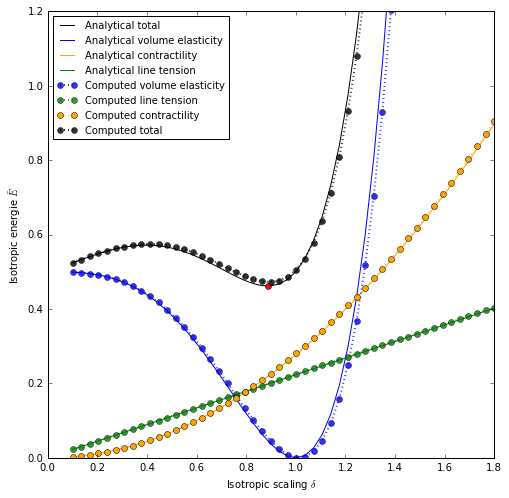

In [7]:
from tyssue.draw.plt_draw import plot_analytical_to_numeric_comp
fig, ax = plot_analytical_to_numeric_comp(sheet, model, geom, iso, nondim_specs)


In [8]:
model.compute_energy(sheet) / sheet.face_df.is_alive.sum()

0.46457789908130687

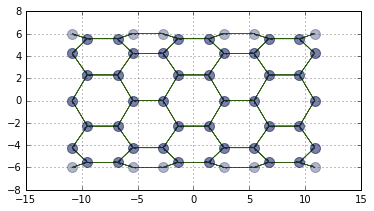

In [9]:
isotropic_relax(sheet, nondim_specs)

fig, ax = sheet_view(sheet, ['z', 'x'])

In [10]:
grad_t, grad_c, grad_v_srce, grad_v_trgt = model.compute_gradient(sheet, components=True)


In [11]:
grad_i = model.compute_gradient(sheet, components=False)
grad_i.head()

,x,y,z
srce,,,
0,0.004460,1.776357e-17,-0.014001
1,-0.006905,-2.860315e-03,-0.012965
2,0.003154,3.153586e-03,-0.014001
3,-0.006905,2.860315e-03,-0.012965
4,-0.002785,1.153606e-03,-0.001036


In [12]:
geom.scale(sheet, 2, sheet.coords)
geom.update_all(sheet)

In [13]:
bck_lt = sheet.edge_df.line_tension.copy()
bck_ct = sheet.face_df.contractility.copy()
bck_ve = sheet.face_df.vol_elasticity.copy()


In [ ]:
# sheet.edge_df.line_tension = 0
# sheet.face_df.vol_elasticity = 0
# sheet.face_df.contractility = 0

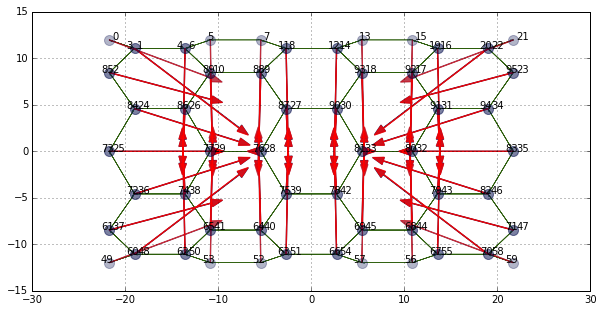

In [15]:
scale = 10
fig, ax = draw.plot_forces(sheet, geom, model, ['z', 'x'], scale)
fig.set_size_inches(10, 12)
for n, (vx, vy, vz) in sheet.vert_df[sheet.coords].iterrows():
    shift = 0.6 * np.sign(vy)
    ax.text(vz+shift-0.3, vx, str(n))

app_grad_specs = config.draw.sheet_spec()['grad']
app_grad_specs.update({'color':'r'})
    
def draw_approx_force(ax=None):
    fig, ax = draw.plot_forces(sheet, geom, model,
                              ['z', 'x'], scaling=scale, ax=ax,
                              approx_grad=solver.approx_grad, **{'grad':app_grad_specs})
    fig.set_size_inches(10, 12)
    return fig, ax

## Uncomment bellow to recompute
fig, ax = draw_approx_force(ax=ax)
#fig

In [ ]:
sheet.edge_df.line_tension = bck_lt.copy()
sheet.face_df.contractility = bck_ct.copy()
sheet.face_df.vol_elasticity = bck_ve.copy()

http://scipy.github.io/devdocs/generated/scipy.optimize.check_grad.html#scipy.optimize.check_grad

In [16]:

grad_err = solver.check_grad(sheet, geom, model)
grad_err /= sheet.vert_df.size


print("Error on the gradient (non-dim, per vertex): {:.3e}".format(grad_err))


Error on the gradient (non-dim, per vertex): 6.258e-05


In [17]:
settings = {
    'minimize': {
        'options': {'disp':False,
                    'ftol':1e-5,
                    'gtol':1e-5},
        }
    }


res = solver.find_energy_min(sheet, geom, model, **settings)
print(res['success'])

True


In [18]:
res['message']

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [19]:
res['fun']/sheet.face_df.is_alive.sum()

0.46087934001864317

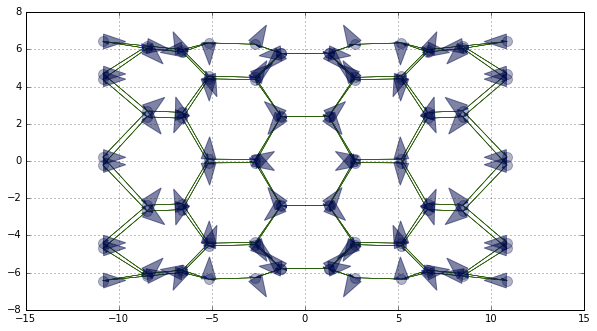

In [20]:
fig, ax = draw.plot_forces(sheet, geom, model, ['z', 'y'], 1)
fig.set_size_inches(10, 12)


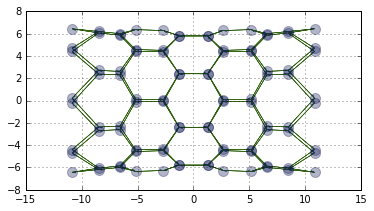

In [21]:
fig, ax = sheet_view(sheet, ['z', 'x'])